In [8]:
import collections
import csv
import keras
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import time
import shap
import ROOT as root
from sklearn.preprocessing import StandardScaler

from keras import optimizers
from keras.regularizers import l2
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add
from keras import activations
from ROOT import TFile, TLorentzVector

from tools.constants import *

In [9]:
""" Data augmentation. """
def random_rotation(X,deltas_phi,num_vectors,met):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi)
    else:
        return X


def random_rotation_MET(X, deltas_phi):

    R = np.sqrt((X[:,-11]**2 + X[:,-10]**2))
    old_phis = np.arctan2(X[:,-10],(X[:,-11]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,-11] = angles_cos * R
    X[:,-10] = angles_sin * R

    return X


def data_rotation(X, num_vectors_X = 11, met = True):   
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met)
        
    return X

""" Data generator for serving the NN data. """
# modified from source: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, scaler = ["scaler_params/X_scaler_mass_reco_wide_btags.csv","scaler_params/y_scaler_higgs_masses_wide_btags.csv"], batch_size=32, n_features=72, shuffle=True, augmentation = True, ceil = False):
        self.n_features = n_features
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.ceil = ceil
        self.indexes = np.arange(len(X))
        with open(scaler[0]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.X_scaler = scaler_params[0:2,:]
        with open(scaler[1]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.y_scaler = scaler_params[0:2]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.ceil:
            return int(np.ceil(len(self.X) / self.batch_size))
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y, weights = self.__data_generation(indexes)
        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)

        X = self.X[indexes]

        weights = X[:,-1]
        X = X[:,:-1]

        y = self.y[indexes]

        if self.augmentation:
            X = data_rotation(X, num_vectors_X = 11, met = True)
        X = (X-self.X_scaler[0])/self.X_scaler[1]     # Standardize
        y = (y-self.y_scaler[0])/self.y_scaler[1]     # Standardize

        return X, y, weights
    
    def get_all(self):
        'Get all data - all batches.'
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [10]:
# Load data.

def add_weights(tth,ttz,ttw,tt):
    """ Class weights, because of the imbalance between the productions' number of events. """
    bg_weight = (len(ttz)+len(tth)+len(ttw)+len(tt))/2/(len(ttz)+len(ttw)+len(tt))
    h_weight = (len(ttz)+len(tth)+len(ttw)+len(tt))/2/len(tth)
    
    print(bg_weight)
    print(h_weight)

    ones = np.ones((tth.shape[0],1))
    tth = np.concatenate((tth, h_weight*ones),axis=1)

    ones = np.ones((ttz.shape[0],1))
    ttz = np.concatenate((ttz, bg_weight*ones),axis=1)

    ones = np.ones((ttw.shape[0],1))
    ttw = np.concatenate((ttw, bg_weight*ones),axis=1)

    ones = np.ones((tt.shape[0],1))
    tt = np.concatenate((tt, bg_weight*ones),axis=1)
    return tth,ttz,ttw,tt

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttH.csv") as f: 
    X_y_train_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttZ.csv") as f: 
    X_y_train_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_train_ttW.csv") as f: 
    X_y_train_ttW = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_train_tt.csv") as f: 
    X_y_train_tt = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttH.csv") as f: 
    X_y_test_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttZ.csv") as f: 
    X_y_test_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_test_ttW.csv") as f: 
    X_y_test_ttW = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_test_tt.csv") as f: 
    X_y_test_tt = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttH.csv") as f: 
    X_y_val_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttZ.csv") as f: 
    X_y_val_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_val_ttW.csv") as f: 
    X_y_val_ttW = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_wide_selection_btags_val_tt.csv") as f: 
    X_y_val_tt = np.loadtxt(f, delimiter=",", skiprows=1)

X_y_train_ttH, X_y_train_ttZ, X_y_train_ttW, X_y_train_tt = add_weights(X_y_train_ttH, X_y_train_ttZ, X_y_train_ttW, X_y_train_tt)   # Add weights to the data
X_y_train = np.concatenate((X_y_train_ttH, X_y_train_ttZ, X_y_train_ttW, X_y_train_tt), axis=0)                                      # Combine ttH and ttZ for training.
X_train = np.concatenate((X_y_train[:,:-10], X_y_train[:,-6:]), axis = 1)                                                            # Separate X ...   
y_train = X_y_train[:,-10:-6]                                                                                                        # ... and y.
y_train_masses = np.empty((y_train.shape[0],1))                                                                                      # From y we will calculate masses - we use those as labels.

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_train)):              # For each event calculate the Higgs/Z boson mass.
    v = y_train[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_train_masses[i] = vec.Mag()

X_y_val_ttH, X_y_val_ttZ, X_y_val_ttW, X_y_val_tt = add_weights(X_y_val_ttH, X_y_val_ttZ, X_y_val_ttW, X_y_val_tt)  # Repeat for val and test...
X_y_val = np.concatenate((X_y_val_ttH, X_y_val_ttZ, X_y_val_ttW, X_y_val_tt), axis=0)
X_val = np.concatenate((X_y_val[:,:-10], X_y_val[:,-6:]), axis = 1) 
y_val = X_y_val[:,-10:-6]
y_val_masses = np.empty((y_val.shape[0],1))

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_val)):
    v = y_val[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_val_masses[i] = vec.Mag()

X_y_test_ttH, X_y_test_ttZ, X_y_test_ttW, X_y_test_tt = add_weights(X_y_test_ttH, X_y_test_ttZ, X_y_test_ttW, X_y_test_tt)
X_y_test = np.concatenate((X_y_test_ttH, X_y_test_ttZ, X_y_test_ttW, X_y_test_tt), axis=0)
X_test = np.concatenate((X_y_test[:,:-10], X_y_test[:,-6:]), axis = 1)  
y_test = X_y_test[:,-10:-6]
y_test_masses = np.empty((y_test.shape[0],1))

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_test)):
    v = y_test[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_test_masses[i] = vec.Mag()

num_features = X_train.shape[1]-1   # exclude weights
num_samples = X_train.shape[0]

print(num_features,num_samples)

0.7999834526124188
1.3333793008343102
0.7996011964107677
1.3344425956738768
0.800198478332782
1.3327823691460055
76 38676


In [11]:
train_generator = DataGenerator(X_train, y_train_masses, n_features = num_features, batch_size=4096, shuffle=True, augmentation = True, ceil = False)
val_generator = DataGenerator(X_val, y_val_masses, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)
test_generator = DataGenerator(X_test, y_test_masses, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)

In [12]:
""" Get scaler params... """
""" X_train = np.empty((num_samples,num_features), dtype=float)
y_train_masses = np.empty((num_samples,1), dtype=float)
c = 0

for i in range(len(train_generator)):
    rows = len(train_generator[i][0][:])

    X_train[c:c+rows,:] = train_generator[i][0][:]
    y_train_masses[c:c+rows,:] = train_generator[i][1][:]
    c += rows

X_train = X_train[1:,:]
y_train_masses = y_train_masses[1:,:]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_train)
y_scaler = y_scaler.fit(y_train_masses)

f = open("scaler_params/X_scaler_mass_reco_wide_btags.csv", "w")
writer = csv.writer(f)
writer.writerow(X_scaler.mean_)
writer.writerow(X_scaler.scale_)
f.close()

f = open("scaler_params/y_scaler_higgs_masses_wide_btags.csv", "w")
writer = csv.writer(f)
writer.writerow(y_scaler.mean_)
writer.writerow(y_scaler.scale_)
f.close() """

' X_train = np.empty((num_samples,num_features), dtype=float)\ny_train_masses = np.empty((num_samples,1), dtype=float)\nc = 0\n\nfor i in range(len(train_generator)):\n    rows = len(train_generator[i][0][:])\n\n    X_train[c:c+rows,:] = train_generator[i][0][:]\n    y_train_masses[c:c+rows,:] = train_generator[i][1][:]\n    c += rows\n\nX_train = X_train[1:,:]\ny_train_masses = y_train_masses[1:,:]\nX_scaler = StandardScaler()\ny_scaler = StandardScaler()\nX_scaler = X_scaler.fit(X_train)\ny_scaler = y_scaler.fit(y_train_masses)\n\nf = open("scaler_params/X_scaler_mass_reco_wide_btags.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(X_scaler.mean_)\nwriter.writerow(X_scaler.scale_)\nf.close()\n\nf = open("scaler_params/y_scaler_higgs_masses_wide_btags.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(y_scaler.mean_)\nwriter.writerow(y_scaler.scale_)\nf.close() '

In [13]:
""" Define NN architecture. """
def baseline_model(num_features):

    i = keras.Input(shape = (num_features,))
    dropout_1 = Dropout(0.2)(i)
    dense_1 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_1)
    relu_1 = Activation(activations.relu)(dense_1)

    dropout_2 = Dropout(0.2)(relu_1)
    dense_2 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_2)
    relu_2 = Activation(activations.relu)(dense_2)

    dropout_3 = Dropout(0.2)(relu_2)
    dense_3 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_3)
    relu_3 = Activation(activations.relu)(dense_3)

    dropout_4 = Dropout(0.2)(relu_3)
    dense_4 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_4)
    relu_4 = Activation(activations.relu)(dense_4)

    dropout_5 = Dropout(0.2)(relu_4)
    dense_5 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_5)
    relu_5 = Activation(activations.relu)(dense_5)

    dropout_6 = Dropout(0.2)(relu_5)
    dense_6 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_6)
    relu_6 = Activation(activations.relu)(dense_6)

    dropout_7 = Dropout(0.2)(relu_6)
    o = Dense(1, activation='linear', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_7)

    model = keras.Model(i, o)
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.0005, beta_1=0.9))
    model.summary()
    return model

def scheduler(epoch, lr):
    return lr * 0.99

In [14]:
""" Training. Callbacks used are learning rate decay and early stopping. """
model = baseline_model(num_features)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=train_generator, validation_data = val_generator, epochs=300, verbose=1, callbacks = [callback1, callback2])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 76)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 760)               58520     
_________________________________________________________________
activation_6 (Activation)    (None, 760)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 760)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 760)               578360    
_________________________________________________________________
activation_7 (Activation)    (None, 760)               0   

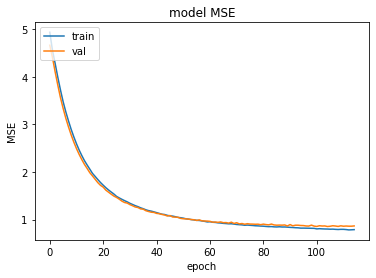

<Figure size 432x288 with 0 Axes>

In [15]:
""" Training history plot. """

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0.6,1)
plt.show()
plt.clf()

In [16]:
""" Save model. """
model.save("models/mass_reco_wide_btags")

INFO:tensorflow:Assets written to: models/mass_reco_wide_btags/assets


2022-01-04 09:22:45.038342: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


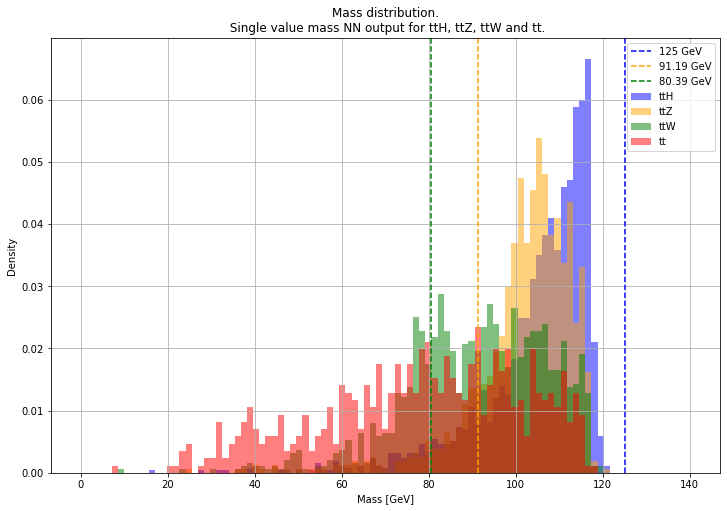

105.08823 12.676256


In [20]:
""" Pyplot histogram. """

from scipy.optimize import curve_fit
from scipy.stats import crystalball, norm

ttH_eval_generator = DataGenerator(np.concatenate((X_y_test_ttH[:,:-10], X_y_test_ttH[:,-6:]), axis = 1), y_test_masses[:len(X_y_test_ttH)], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)
ttZ_eval_generator = DataGenerator(np.concatenate((X_y_test_ttZ[:,:-10], X_y_test_ttZ[:,-6:]), axis = 1), y_test_masses[len(X_y_test_ttH):len(X_y_test_ttH)+len(X_y_test_ttZ)], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)
ttW_eval_generator = DataGenerator(np.concatenate((X_y_test_ttW[:,:-10], X_y_test_ttW[:,-6:]), axis = 1), y_test_masses[len(X_y_test_ttH)+len(X_y_test_ttZ):len(X_y_test_ttH)+len(X_y_test_ttZ)+len(X_y_test_ttW)], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)
tt_eval_generator = DataGenerator(np.concatenate((X_y_test_tt[:,:-10], X_y_test_tt[:,-6:]), axis = 1), y_test_masses[len(X_y_test_ttH)+len(X_y_test_ttZ)+len(X_y_test_ttW):], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)

ttH_y_pred = model.predict(ttH_eval_generator)
X_y = ttH_eval_generator.get_all()
ttH_X_eval = X_y[0]
ttH_y_true = X_y[1]

ttZ_y_pred = model.predict(ttZ_eval_generator)
X_y = ttZ_eval_generator.get_all()
ttZ_X_eval = X_y[0]
ttZ_y_true = X_y[1]

ttW_y_pred = model.predict(ttW_eval_generator)
X_y = ttW_eval_generator.get_all()
ttW_X_eval = X_y[0]
ttW_y_true = X_y[1]

tt_y_pred = model.predict(tt_eval_generator)
X_y = tt_eval_generator.get_all()
tt_X_eval = X_y[0]
tt_y_true = X_y[1]

""" Scale in the opposite direction, to get the mass in MeV. """
with open("scaler_params/y_scaler_higgs_masses_wide_btags.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    y_scaler = scaler_params[0:2]

ttH_y_true = ttH_y_true * y_scaler[1] + y_scaler[0]
ttH_y_pred = ttH_y_pred * y_scaler[1] + y_scaler[0]

ttZ_y_true = ttZ_y_true * y_scaler[1] + y_scaler[0]
ttZ_y_pred = ttZ_y_pred * y_scaler[1] + y_scaler[0]

ttW_y_true = ttW_y_true * y_scaler[1] + y_scaler[0]
ttW_y_pred = ttW_y_pred * y_scaler[1] + y_scaler[0]

tt_y_true = tt_y_true * y_scaler[1] + y_scaler[0]
tt_y_pred = tt_y_pred * y_scaler[1] + y_scaler[0]

with open("scaler_params/X_scaler_mass_reco_wide_btags.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    X_scaler = scaler_params[0:2,:]

ttH_X_eval = ttH_X_eval * X_scaler[1] + X_scaler[0]
ttZ_X_eval = ttZ_X_eval * X_scaler[1] + X_scaler[0]
ttW_X_eval = ttW_X_eval * X_scaler[1] + X_scaler[0]
tt_X_eval = tt_X_eval * X_scaler[1] + X_scaler[0]

predicted_higgs_masses = []
predicted_Z_masses = []

VIS_TAU_HADR_INDEX = 12
VIS_TAU_LEP_INDEX = 28

plt.figure(figsize=(12,8))
plt.hist(ttH_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='blue')
plt.hist(ttZ_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='orange')
plt.hist(ttW_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='green')
plt.hist(tt_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='red')
plt.axvline(125,color='blue', linestyle='dashed')
plt.axvline(91.19,color='orange', linestyle='dashed')
plt.axvline(80.39,color='green', linestyle='dashed')

plt.title("Mass distribution.\n Single value mass NN output for ttH, ttZ, ttW and tt.")
plt.xlabel("Mass [GeV]")
plt.ylabel("Density")
plt.legend(["125 GeV","91.19 GeV","80.39 GeV","ttH","ttZ","ttW","tt"])
plt.grid()
plt.savefig("figures/mass_histo_wide_pyplot_btags.pdf")
plt.show()

print(np.mean(ttH_y_pred/1000),np.std(ttH_y_pred/1000))

1.3327823691460055
0.800198478332782


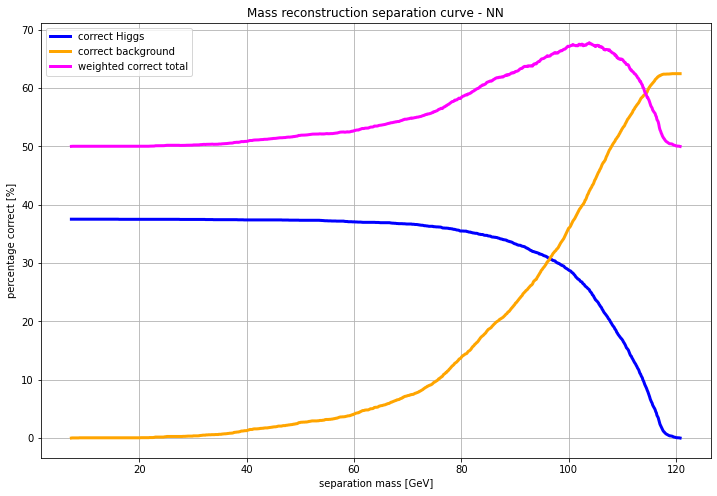

67.77447284318845


In [18]:
""" Separation curve. """

min_mass = np.min(np.concatenate((ttH_y_pred, ttZ_y_pred, ttW_y_pred, tt_y_pred)))
max_mass = np.max(np.concatenate((ttH_y_pred, ttZ_y_pred, ttW_y_pred, tt_y_pred)))

bg_weight = (len(ttZ_y_pred)+len(ttH_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/2/(len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))
h_weight = (len(ttZ_y_pred)+len(ttH_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/2/len(ttH_y_pred)
print(h_weight)
print(bg_weight)

n_steps = 1000
step_size = (max_mass-min_mass)/n_steps
current_divider = min_mass

correct_h = np.zeros((n_steps))
correct_bg = np.zeros((n_steps))

incorrect_h = np.zeros((n_steps))
incorrect_bg = np.zeros((n_steps))

steps = np.zeros((n_steps))

for i in range(n_steps):

    current_divider = min_mass+i*step_size
    steps[i] = current_divider

    for h_mass in ttH_y_pred:
        if h_mass < current_divider:
            incorrect_h[i] += 1
        else:
            correct_h[i] += 1

    for z_mass in ttZ_y_pred:
        if z_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1
    for W_mass in ttW_y_pred:
        if W_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1
    for _0_mass in tt_y_pred:
        if _0_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1

steps = steps/1000
correct_h /= (len(ttH_y_pred)+len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/100
correct_bg /= (len(ttH_y_pred)+len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/100
plt.figure(figsize=(12,8))
plt.plot(steps, correct_h, linewidth=3, color='blue')
plt.plot(steps, correct_bg, linewidth=3, color='orange')
plt.plot(steps, h_weight*correct_h + bg_weight*correct_bg, linewidth=3, color='magenta')
plt.title("Mass reconstruction separation curve - NN")
plt.xlabel("separation mass [GeV]")
plt.ylabel("percentage correct [%]")
plt.legend(["correct Higgs","correct background","weighted correct total"])
plt.grid()
plt.savefig("figures/mass_histo_wide_separation_btags.pdf")
plt.show()
print(np.max(h_weight*correct_h + bg_weight*correct_bg))

In [23]:
""" ROOT histogram. """

import atlasplots as aplt
import root_numpy
from ROOT import TF1, TLine

aplt.set_atlas_style()

H_line = TLine(125.18,0,125.18,10000)
H_line.SetLineStyle(9)
H_line.SetLineWidth(3)
Z_line = TLine(91.19,0,91.19,10000)
Z_line.SetLineStyle(9)
Z_line.SetLineWidth(3)
W_line = TLine(80.38,0,80.38,10000)
W_line.SetLineStyle(9)
W_line.SetLineWidth(3)
null_line = TLine(0,0,0,10000)
null_line.SetLineStyle(9)
null_line.SetLineWidth(3)

gauss_fit_2 = TF1("gauss_fit_2","gaus(0)",80,140)
gauss_fit_2.SetParameters(2000, 110, 10)



ttH = root.TH1F("ttH","",30,20,150)
root_numpy.fill_hist(ttH, ttH_y_pred.flatten()/1000)

weights1 = np.ones(len(ttZ_y_pred))*(len(ttH_y_pred)/len(ttZ_y_pred))

ttZ = root.TH1F("ttZ","",30,20,150)
root_numpy.fill_hist(ttZ, ttZ_y_pred.flatten()/1000, weights1)

weights2 = np.ones(len(ttW_y_pred))*(len(ttH_y_pred)/len(ttW_y_pred))

ttW = root.TH1F("ttZ","",30,20,150)
root_numpy.fill_hist(ttW, ttW_y_pred.flatten()/1000, weights2)

weights3 = np.ones(len(tt_y_pred))*(len(ttH_y_pred)/len(tt_y_pred))

tt = root.TH1F("ttZ","",30,20,150)
root_numpy.fill_hist(tt, tt_y_pred.flatten()/1000, weights3)



fig, ax = aplt.subplots(1, 1)

ttH.Fit("gauss_fit_2","0")
gauss_fit_2.SetNpx(1000)
#ax.plot(gauss_fit_2, label="Fit", labelfmt="L", linecolor=root.kRed+1, linewidth=3)



ttH_fit = ttH.GetFunction("gauss_fit_2")
print(ttH_fit.GetParameter(0))
print(ttH_fit.GetParameter(1))
print(ttH_fit.GetParameter(2))
ax.plot(H_line, linecolor='black', label=None, labelfmt="L")
ax.plot(Z_line, linecolor='black', label=None, labelfmt="L")
ax.plot(W_line, linecolor='black', label=None, labelfmt="L")
#ax.plot(null_line, linecolor='black', label=None, labelfmt="L")
ax.plot(ttH, linecolor='blue', linewidth=3, label="ttH", labelfmt="L")
ax.plot(ttZ, linecolor=807, linewidth=3, label="ttZ", labelfmt="L")
ax.plot(ttW, linecolor=root.kGreen+1, linewidth=3, label="ttW", labelfmt="L")
ax.plot(tt, linecolor=root.kViolet-2, linewidth=3, label="tt", labelfmt="L")
ax.set_xlim(20, 150)
ax.set_ylim(0, 500)
ax.set_xlabel("Mass [GeV]")
ax.set_ylabel("Events")
ax.add_margins(top=0.15)
ax.legend(loc=(0.85, 0.7, 0.95, 0.92))
fig.savefig("figures/mass_histo_wide_root_btags.pdf")

Applying ATLAS style settings
358.18401844721683
107.79996537879236
6.232391376665404
 FCN=527.856 FROM MIGRAD    STATUS=CONVERGED     104 CALLS         105 TOTAL
                     EDM=4.47204e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.58184e+02   1.44189e+01   1.12145e-01   2.20978e-06
   2  Mean         1.07800e+02   2.94042e-01   1.98413e-03  -4.10939e-04
   3  Sigma        6.23239e+00   1.84027e-01   3.87049e-05  -1.93502e-02


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To